# Word embeddings approach using LSA/LSI

Though the fuzzy similarity approach (based on Levenshtein distance)
seem to work on several cases in the USP data,
most of the correct results should be *almost* normalized
in order to have a small edit distance.
The fuzzy approach will neither fill empty fields,
nor fix huge mistakes in what had been filled.
To do that, we were looking at the remaining fields
using a graph approach.
The adjacency matrix entries should be normalized
using both the row and column frequencies,
but that won't fix entries
whose contents had been "swapped" among the columns.

The goal here is to use a topic modeling approach,
using a word embedding matrix
instead of using the CSV columns
(i.e., each word is a feature, no matter where it came from).
This is a Latent Semantic Analysis (LSA) from the TF-IDF matrix,
ending with a K Nearest Neighbors classification model
to fill the empty fields.

*PS: LSI stands for Latent Semantic Indexing.*

In [1]:
import random
import re

Install the following packages with:

```
pip install gensim matplotlib numpy pandas unidecode
```

In [2]:
from gensim import corpora, matutils, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from unidecode import unidecode

In [3]:
random.seed(42)
pd.options.display.max_colwidth = 400 # Avoid "..." in large strings
pd.options.display.max_rows = 120     # Avoid "..." in the table representation of lengthy dataframes
%matplotlib inline

## Pre-normalized word list

We'll get only the words in the fields that aren't IDs/numbers/symbols,
and pre-normalize it by removing accents and symbols,
and by lowercasing everything.

It's the same CSV from Clea's output analyzed in the previous experiments.

In [4]:
TEXT_ONLY_REGEX = re.compile("[^a-zA-Z ]")

In [5]:
def pre_normalize(name):
    return TEXT_ONLY_REGEX.sub("", unidecode(name).lower())

In [6]:
dataset = pd.read_csv("inner_join_2018-06-04.csv",
                      dtype=str,
                      keep_default_na=False) \
            .drop_duplicates()

In [7]:
fields = [
    "addr_city",
    "addr_country",
    "addr_country_code",
    "addr_state",
    "aff_text",
    "article_title",
    "contrib_bio",
    "contrib_prefix",
    "contrib_name",
    "contrib_surname",
    "institution_orgdiv1",
    "institution_orgdiv2",
    "institution_orgname",
    "institution_orgname_rewritten",
    "institution_original",
    "institution_orgname_rewritten",
    "journal_title",
    "publisher_name",
]

In [8]:
word_lists = dataset[fields].T.apply(lambda row: pre_normalize(" ".join(row)).split())
word_lists.head()

0    [brazil, br, e, doutora, em, sociologia, pela, universidade, federal, do, rio, grande, do, sul, ufrgs, e, professora, do, programa, de, posgraduacao, em, ciencia, politica, e, do, programa, de, posgraduacao, em, politicas, publicas, desta, mesma, universidade, email, ligiamorimadeiragmailcom, universidade, federal, do, rio, grande, do, sul, universidade, federal, do, rio, grande, do, sul, ufrg...
1    [brazil, br, e, professor, do, departamento, de, sociologia, da, universidade, federal, do, rio, grande, do, sul, ufrgs, integrando, o, programa, de, posgraduacao, em, sociologia, e, o, programa, de, posgraduacao, em, desenvolvimento, rural, coordena, o, grupo, de, pesquisa, associativismo, contestacao, e, engajamento, gpace, wwwufrgsbrgpace, email, mksilvaufrgsbr, universidade, federal, do, r...
2    [brazil, br, e, professora, do, instituto, federal, sulriograndense, ifsul, campus, sapucaia, do, sul, doutoranda, no, programa, de, posgraduacao, em, sociologia, integra, o, gpace, ema

The $5$ word lists above regards to the first $5$ entries in the CSV.
Are we able to predict the empty fields from an embedding
created from the word lists?

At first, there are too many distinct words!
We should remove words that won't help us.

In [9]:
dictionary = corpora.Dictionary(word_lists)
len(dictionary) # "Raw" word count

102136

Let's remove:

* Words that appear in less than $3$ documents (rows of the CSV);
* Some cherry-picked Brazilian Portuguese stop words;
* Words that has only a single character (`d`, `y`, `a`, `o`, etc.).

In [10]:
uncommon_words = [token for token, tid in dictionary.token2id.items() if dictionary.dfs[tid] <= 2]
stop_words = ["da", "de", "desta", "do", "em", "ii", "iii", "in", "mesma", "no", "pela", "pelos"]
single_char_words = [token for token in dictionary.token2id if len(token) == 1]

In [11]:
dictionary.filter_tokens(bad_ids=[dictionary.token2id[token]
                                  for token in uncommon_words + stop_words + single_char_words])
dictionary.compactify()
len(dictionary) # Word count after filtering

48712

More than half of the words had been removed.

## BoW and TF-IDF

The *bag of words* model for the entire corpus
and the TF-IDF are:

In [12]:
corpus = [dictionary.doc2bow(wlist) for wlist in word_lists]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

Let's see what's going on for the first few words and documents.

In [13]:
num2plot = 400
csc_corpus = matutils.corpus2csc(corpus, num_terms=len(dictionary))
csc_tfidf = matutils.corpus2csc(corpus_tfidf, num_terms=len(dictionary))

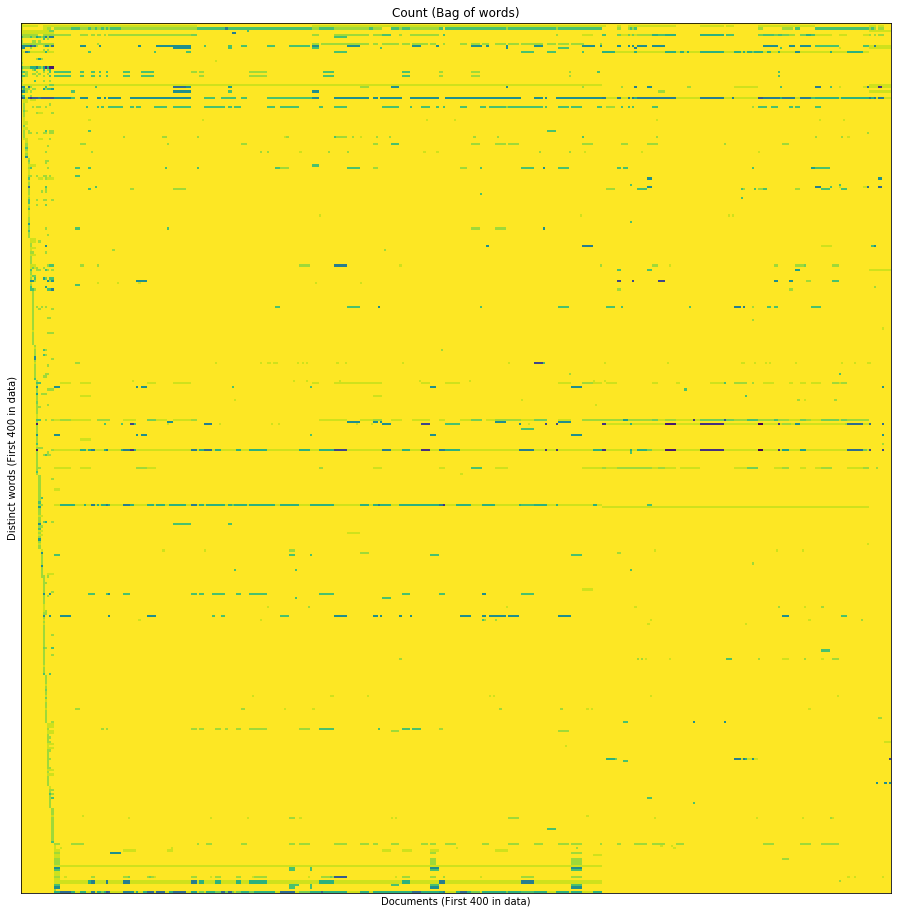

In [14]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(csc_corpus[:num2plot, :num2plot].todense(), cmap=plt.cm.viridis_r)
ax.set(title="Count (Bag of words)",
       xticks=[], xlabel=f"Documents (First {num2plot} in data)",
       yticks=[], ylabel=f"Distinct words (First {num2plot} in data)");

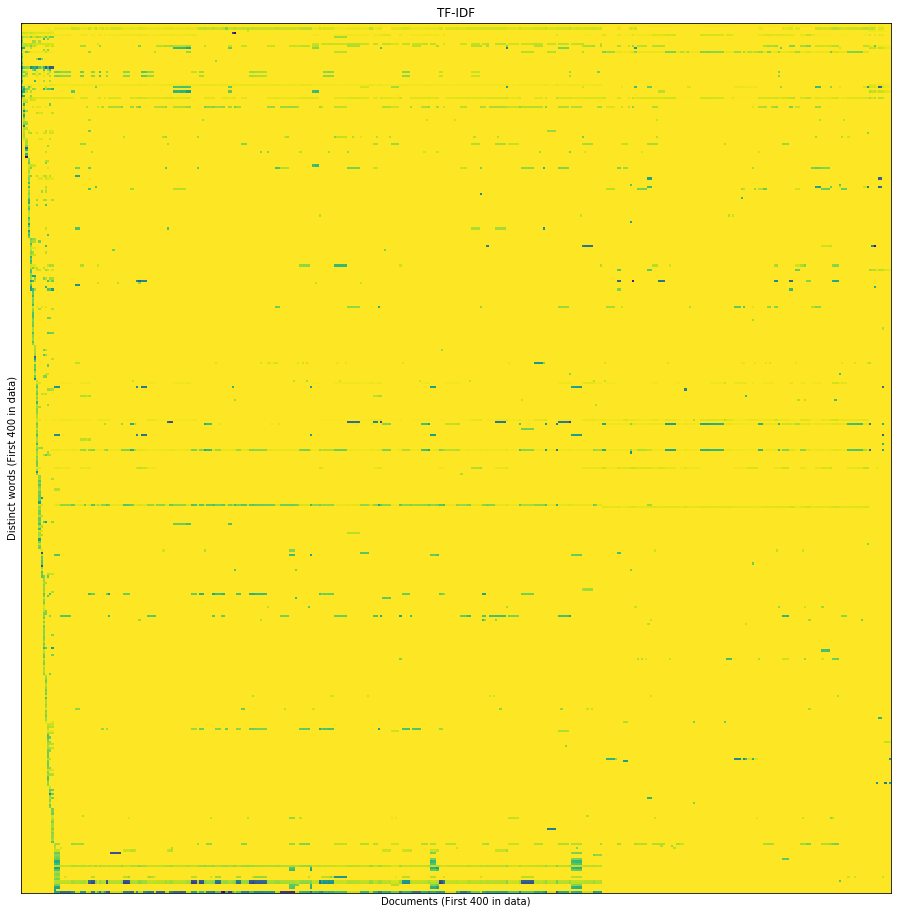

In [15]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(csc_tfidf[:num2plot, :num2plot].todense(), cmap=plt.cm.viridis_r)
ax.set(title="TF-IDF",
       xticks=[], xlabel=f"Documents (First {num2plot} in data)",
       yticks=[], ylabel=f"Distinct words (First {num2plot} in data)");

Each row in these plots regards to a single word,
and each column regards to a single document
(an affiliation-contributor `<aff>` and `<contrib>` pair).
The first plot has the raw count of words in each cell
(each column is a *bag of words*).

The "line" with a quite negative slope at the left
happens due to the first time each word appeared in the documents,
as we're seeing the first indices in the dictionary.
The horizontal line at the bottom shows that there's a single word
that appears in several documents, but the lack of greenish elements
at its right shows it's quite informative:
the simplest approach to a classification would be querying
if that word appears in the document.

The distinction between the *Count/BoW* plot and the *TF-IDF* plot
is of a normalization nature.
TF-IDF means *Term Frequency (times) Inverse Document Frequency*,
that is:

$$
\operatorname{tfidf}(t, d, D) = \operatorname{tf}(t, d) \cdot \operatorname{idf}(t, D)
$$

Where $t$ is a term, $d$ is a document and $D$ is the dictionary.
In the `gensim` implementation,
$\operatorname{tf}$ is the raw term count in the document,
$\operatorname{idf}$ is the negative logarithm (base $2$) of the proportion of
documents that have the given term,
and the overall result (i.e., the vector of TF-IDF for a given document)
is normalized/scaled to unit norm/length.

Let's try to see this result by plotting the $400$ words
and $400$ documents whose TF-IDF entries have the largest variances
(row-wise for the terms/words, column-wise for the documents).

In [16]:
var_docs = (
    csc_tfidf.power(2).mean(axis=0) - csc_tfidf.mean(axis=0).A ** 2
).A.ravel()
var_terms = (
    csc_tfidf.power(2).mean(axis=1) - csc_tfidf.mean(axis=1).A ** 2
).A.ravel()

maxvar_docs_idx = np.argsort(var_docs)[-num2plot:]
maxvar_terms_idx = np.argsort(var_terms)[-num2plot:]

csc_corpus_block = csc_corpus[maxvar_terms_idx].T \
                             [maxvar_docs_idx].T.todense()
csc_tfidf_block = csc_tfidf[maxvar_terms_idx].T \
                           [maxvar_docs_idx].T.todense()

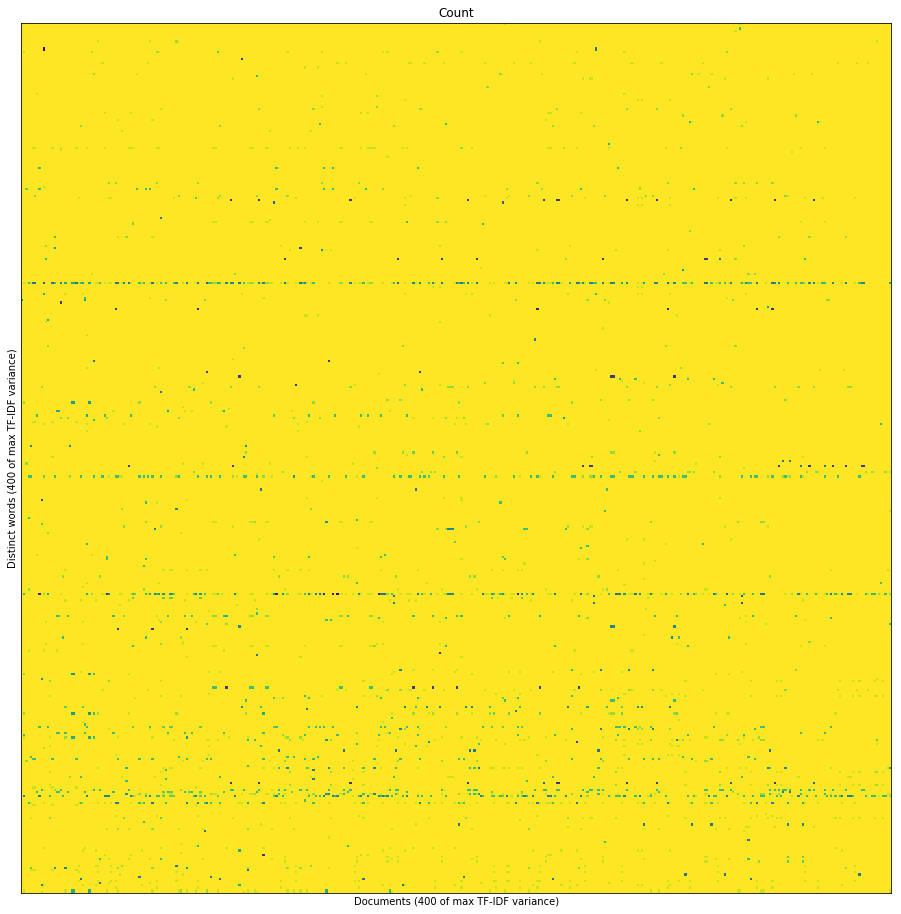

In [17]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(csc_corpus_block, cmap=plt.cm.viridis_r)
ax.set(title="Count",
       xticks=[], xlabel=f"Documents ({num2plot} of max TF-IDF variance)",
       yticks=[], ylabel=f"Distinct words ({num2plot} of max TF-IDF variance)");

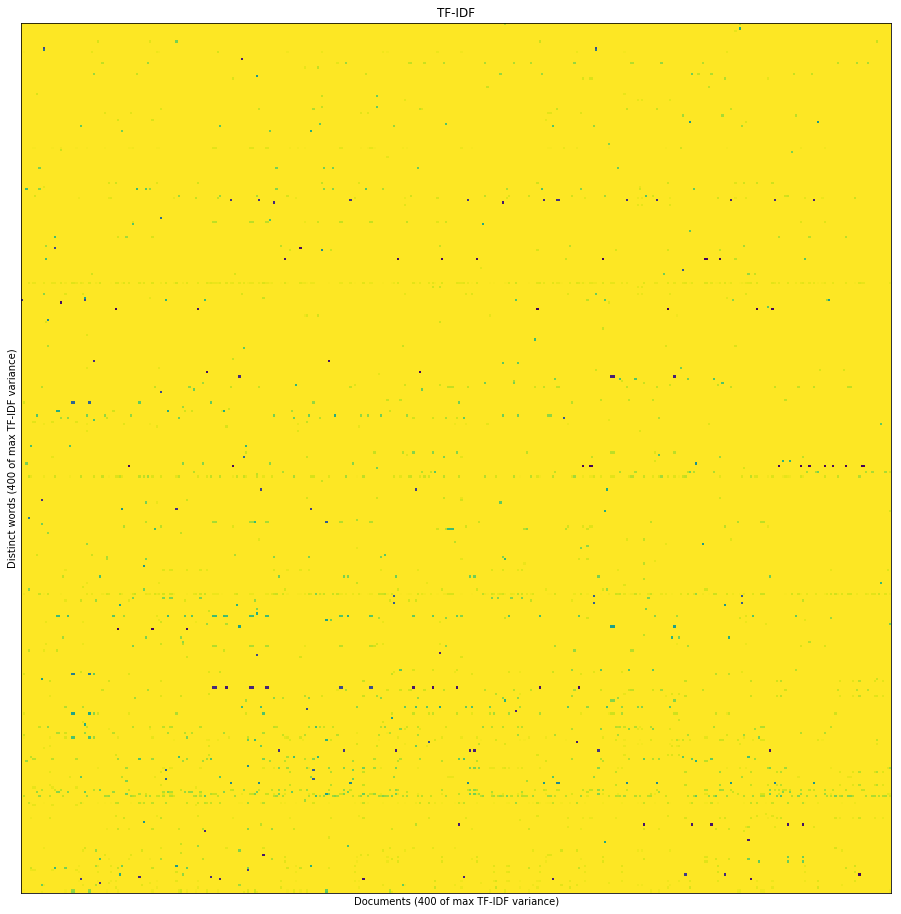

In [18]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(csc_tfidf_block, cmap=plt.cm.viridis_r)
ax.set(title="TF-IDF",
       xticks=[], xlabel=f"Documents ({num2plot} of max TF-IDF variance)",
       yticks=[], ylabel=f"Distinct words ({num2plot} of max TF-IDF variance)");

Though these last images represents the same data,
the TF-IDF is more yellowish / cleaner.
That means a lot of words that has a high value in the BoW model
aren't informative for document discrimination.

## LSI - Latent Semantic Indexing

The randomness suggests there are some information we can directly use to create classifiers.

The goal here is to remove redundancy from that huge matrix by lowering its rank.
The whole idea is to minimize the, given our TF-IDF matrix $\mathbf{X}$, we can perform SVD:

$$
\mathbf{X} = \mathbf{U} \cdot \mathbf{\Sigma} \cdot \mathbf{V}^T
$$

As we know, its transpose is:

$$
\begin{array}{rcl} \displaystyle
\mathbf{X}^T
& \displaystyle = & \displaystyle
  \left( \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T \right)^T
\\ & \displaystyle = & \displaystyle
  \mathbf{V} \mathbf{\Sigma}^T \mathbf{U}^T
\end{array}
$$

Where $\mathbf{U}$ and $\mathbf{V}$ are orthogonal matrices
(i.e., their transpose are their inverse).
Actually their columns are the eigenvectors of
$\mathbf{X} \mathbf{X}^T$ and $\mathbf{X}^T \mathbf{X}$ since:

$$
\begin{array}{rcl} \displaystyle
\mathbf{X} \mathbf{X}^T
& \displaystyle = & \displaystyle
  \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T
  \mathbf{V} \mathbf{\Sigma}^T \mathbf{U}^T
\\ & \displaystyle = & \displaystyle
  \mathbf{U} \mathbf{\Sigma} \mathbf{V}^{-1}
  \mathbf{V} \mathbf{\Sigma}^T \mathbf{U}^T
\\ & \displaystyle = & \displaystyle
  \mathbf{U} \mathbf{\Sigma} \mathbf{\Sigma}^T \mathbf{U}^T
\\ & \displaystyle = & \displaystyle
  \mathbf{U} \mathbf{\Sigma}_U^2 \mathbf{U}^T
\end{array}
$$

And:

$$
\begin{array}{rcl} \displaystyle
\mathbf{X}^T \mathbf{X}
& \displaystyle = & \displaystyle
  \mathbf{V} \mathbf{\Sigma}^T \mathbf{U}^T
  \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T
\\ & \displaystyle = & \displaystyle
  \mathbf{V} \mathbf{\Sigma}^T \mathbf{U}^{-1}
  \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T
\\ & \displaystyle = & \displaystyle
  \mathbf{V} \mathbf{\Sigma}^T \mathbf{\Sigma} \mathbf{V}^T
\\ & \displaystyle = & \displaystyle
  \mathbf{V} \mathbf{\Sigma}_V^2 \mathbf{V}^T
\end{array}
$$

Lowering the rank is just zeroing *the smallest singular values $\sigma_i$ in $\mathbf{\Sigma}$*.
That is, we perform SVD, replace the smallest singular values by zero, and resynthesize the matrix with:

$$
\mathbf{X}_k = \mathbf{U} \cdot \mathbf{\Sigma}_k \cdot \mathbf{V}^T
$$

The magnitude of the matrix measured by its Frobenius norm is also lowered,
but in some sense the changes are the smaller they could be, since
the Frobenius norm of $\mathbf{X}$ is:

$$
||\mathbf{X}||_F = \sqrt{\sum_{i=1}^n \sum_{j=1}^m x_{ij}^2}
                 = \sqrt{\operatorname{tr} \left( \mathbf{X}^T \mathbf{X} \right) }
                 = \sqrt{\operatorname{tr} \left( \mathbf{V} \mathbf{\Sigma}_V^2 \mathbf{V}^T \right) }
                 = \sqrt{\operatorname{tr} \left( \mathbf{V}^T \mathbf{V} \mathbf{\Sigma}_V^2 \right) }
                 = \sqrt{\operatorname{tr} \left( \mathbf{\Sigma}_V^2 \right) }
                 = \sqrt{\sum \sigma_i^2 }
$$

(Remind the trace of a product is invariant under cyclic permutation)